In [1]:
#这次对小数据集进行词级别的机器翻译
import torch
import torch.utils.data as da
import torch.nn as nn
import torch.optim as optim
import jieba
import argparse
import matplotlib.pyplot as plt
from collections import Counter
import random
import time
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
parser = argparse.ArgumentParser()

parser.add_argument('--en_path', type=str, default='data/news-commentary-v13.zh-en.en',
                   help='英文数据集路径')
parser.add_argument('--zh_path', type=str, default='data/news-commentary-v13.zh-en.zh',
                   help='中文数据集路径')
parser.add_argument('--seq_len', type=int, default=60,
                   help='句子最大的长度，多则截断，少则补<unk>')
parser.add_argument('--pad', type=str, default='<unk>',
                   help='填充词')
parser.add_argument('--batch_size',type=int,default=32,
                   help='每轮批次')
parser.add_argument('--en_embedding_dim',type=int,default=256,
                   help='编码器词向量的长度')
parser.add_argument('--en_hidden_dim',type=int,default=512,
                   help='编码器深度')
parser.add_argument('--en_n_layers',type=int,default=2,
                   help='编码器LSTM的层数')
parser.add_argument('--de_embedding_dim',type=int,default=256,
                   help='解码器词向量的长度')
parser.add_argument('--de_hidden_dim',type=int,default=512,
                   help='解码器深度')
parser.add_argument('--de_n_layers',type=int,default=2,
                   help='解码器LSTM的层数')
parser.add_argument('--dropout',type=int,default=0.5,
                   help='droput')
parser.add_argument('--lr',type=int,default=0.0001,
                   help='学习率')
parser.add_argument('--weight_decay',type=int,default=0.1,
                   help='权重衰减/L2范式')
parser.add_argument('--clip',type=int,default=1,
                   help='梯度剪切')
parser.add_argument('--epochs',type=int,default=200,
                   help='训练轮数')
parser.add_argument('--attention',type=bool,default=False,
                   help='是否启用注意力机制')

#kwargs = parser.parse_args()
kwargs = parser.parse_known_args()[0]


In [4]:
# with open(kwargs.en_path, 'r') as f_en:
#     data_en = f_en.readlines()
# with open(kwargs.zh_path, 'r') as f_zh:
#     data_zh = f_zh.readlines()

In [8]:
#用一个小数据集合先玩玩
with open('./cmn-eng/cmn.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data = data.strip()
data = data.split('\n')
# 分割英文数据和中文数据
data_en = [line.split('\t')[0] for line in data]
data_zh = [line.split('\t')[1] for line in data]

In [9]:
#特殊处理
def data_process(text):
    text = text.lower()
    # 特殊数据处理，该地方可以各种替换缩略词等
    # 去除标点等
    return text

In [10]:
#对单句话进行分词
def get_token_text(text_en,text_zh):
    #简单的句子处理
    text_en=text_en.replace('.',' .').replace('?',' ?').replace('!',' !').replace(',',' , ')
    text_zh=text_zh.strip('\n')
    #英文以空格分割
    token_data_en = [data_process(st) for st in text_en.split()]
    #中文一般用jieba
    token_data_zh = [data_process(st) for st in jieba.cut(text_zh)]
    return [token_data_en,token_data_zh]

In [11]:
#对两个数据集的每句话进行分词
def get_token_data(data_en,data_zh):
    data_token_en = []
    data_token_zh = []
    for en,zh in zip(data_en,data_zh):
        en,zh=get_token_text(en,zh)
        data_token_en.append(en)
        data_token_zh.append(zh)
    return data_token_en,data_token_zh

In [12]:
def get_vocab(data):
    data=[j for i in data for j in i]
    top_1000 = Counter(data).most_common(100000)
    vocab = {x[0]:x[1] for x in top_1000}
    word_to_idx = {word: i + 4 for i, word in enumerate(vocab)}
    word_to_idx['<pad>'] = 0
    word_to_idx['<sos>'] = 1
    word_to_idx['<eos>'] = 2
    word_to_idx['<unk>'] = 3
    idx_to_word = {i + 4: word for i, word in enumerate(vocab)}
    idx_to_word[0] = '<pad>'
    idx_to_word[1] = '<sos>'
    idx_to_word[2] = '<eos>'
    idx_to_word[3] = '<unk>'
    vocab_size=len(idx_to_word)
    return vocab, vocab_size, word_to_idx, idx_to_word

In [13]:
# 填充和截断
def pad_st(features, maxlen, pad=0):
    padded_features = []
    for feature in features:
        feature.insert(0,'<sos>')
        feature.append('<eos>')
        if len(feature) > maxlen:
            padded_feature = feature[:maxlen]
            padded_feature[-1]='<eos>'#防止<eos>被切掉
        else:
            padded_feature = feature
            while (len(padded_feature) < maxlen):
                padded_feature.append(pad)
        padded_features.append(padded_feature)
    return padded_features

In [14]:
# 转化为索引
def encode_st(token_data, word_to_idx):
    features = []
    for sample in token_data:
        feature = []
        feature.append(1)
        for token in sample:
            if token in word_to_idx:
                feature.append(word_to_idx[token])
            else:#如果是词库中不存在的，认为是<unk>，即0
                feature.append(0)
        feature.append(2)
        features.append(feature)
    
    return features

In [16]:
#此时为二维数组，每个数组是之前每句话的分词结果，词级别
en_data,zh_data=get_token_data(data_en,data_zh)


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/renhongjie/miniconda3/envs/rencaiji/lib/python3.6/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmp3w23kfg_' -> '/tmp/jieba.cache'
Loading model cost 0.814 seconds.
Prefix dict has been built successfully.


In [17]:
print(en_data[0:2],zh_data[0:2])

[['hi', '.'], ['hi', '.']] [['嗨', '。'], ['你好', '。']]


In [18]:
vocab_en,vocab_size_en, word_to_idx_en, idx_to_word_en=get_vocab(en_data)
vocab_zh,vocab_size_zh, word_to_idx_zh, idx_to_word_zh=get_vocab(zh_data)


In [19]:
kwargs.vocab_size_en=vocab_size_en#记录vocab大小
kwargs.vocab_size_zh=vocab_size_zh#记录vocab大小
print(vocab_size_en,vocab_size_zh)

6904 14719


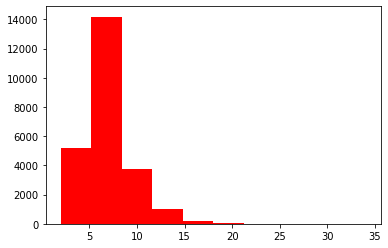

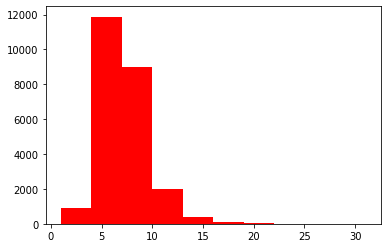

In [20]:
#看一下预料的长度分布，然后选择一个合适的seq_len
en_data_length=[]
for i in en_data:
    en_data_length.append(len(i))
n, bins, patches = plt.hist(en_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()
zh_data_length=[]
for i in zh_data:
    zh_data_length.append(len(i))
n, bins, patches = plt.hist(zh_data_length, bins=10, edgecolor='None',facecolor='red') 
plt.show()

In [21]:
print(zh_data_length[0:10])

[2, 2, 5, 2, 3, 2, 2, 4, 3, 2]


In [22]:
en_data_id=encode_st((en_data),word_to_idx_en)
zh_data_id=encode_st((zh_data),word_to_idx_zh)

In [23]:
print(en_data_id[0:3])

[[1, 1766, 4, 2], [1, 1766, 4, 2], [1, 534, 4, 2]]


In [24]:
from torch.utils.data import Dataset, DataLoader
class TranslationDataset(Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data

        assert len(src_data) == len(trg_data), \
            "numbers of src_data  and trg_data must be equal!"

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_sample =self.src_data[idx]
        src_len = len(self.src_data[idx])
        trg_sample = self.trg_data[idx]
        trg_len = len(self.trg_data[idx])
        return {"src": src_sample, "src_len": src_len, "trg": trg_sample, "trg_len": trg_len}

In [25]:
def padding_batch(batch):
    """
    input: -> list of dict
        [{'src': [1, 2, 3], 'trg': [1, 2, 3]}, {'src': [1, 2, 2, 3], 'trg': [1, 2, 2, 3]}]
    output: -> dict of tensor 
        {
            "src": [[1, 2, 3, 0], [1, 2, 2, 3]].T
            "trg": [[1, 2, 3, 0], [1, 2, 2, 3]].T
        }
    """
    src_lens = [d["src_len"] for d in batch]
    trg_lens = [d["trg_len"] for d in batch]
    
    src_max = max([d["src_len"] for d in batch])
    trg_max = max([d["trg_len"] for d in batch])
    for d in batch:
        word_to_idx_en
        d["src"].extend([word_to_idx_en["<pad>"]]*(src_max-d["src_len"]))
        d["trg"].extend([word_to_idx_zh["<pad>"]]*(trg_max-d["trg_len"]))
    srcs = torch.tensor([pair["src"] for pair in batch], dtype=torch.long, device=device)
    trgs = torch.tensor([pair["trg"] for pair in batch], dtype=torch.long, device=device)
    
    batch = {"src":srcs.T, "src_len":src_lens, "trg":trgs.T, "trg_len":trg_lens}
    return batch

In [26]:
# 数据集
train_set = TranslationDataset(en_data_id, zh_data_id)
train_iter = DataLoader(train_set, batch_size=512, collate_fn=padding_batch)

In [27]:
#开始模型部分
class Encoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.input_dim = args.vocab_size_en
        self.emb_dim = args.en_embedding_dim
        self.hid_dim = args.en_hidden_dim
        self.n_layers = args.en_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.input_dim, self.emb_dim)   
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim, num_layers=self.n_layers,
                           dropout=self.dropout,bidirectional=True)

        
    def forward(self, x,input_lengths):
        embedded = (self.embedding(x))
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, enforce_sorted=False)
        outputs, (hidden, cell) = self.rnn(packed)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(sequence=outputs)
        return outputs,hidden, cell
class Decoder(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.emb_dim = args.de_embedding_dim
        self.hid_dim = args.de_hidden_dim
        self.output_dim = args.vocab_size_zh
        self.n_layers = args.de_n_layers
        self.dropout = args.dropout
        self.embedding = nn.Embedding(self.output_dim, self.emb_dim)
        self.rnn = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hid_dim,num_layers= self.n_layers,
                           dropout=self.dropout,bidirectional=True)
        bidirectional=True
        if bidirectional==True:
            self.out = nn.Linear(self.hid_dim*2, self.output_dim)
        else:
            self.out = nn.Linear(self.hid_dim, self.output_dim)
        self.dropout = nn.Dropout(self.dropout)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden, cell):
        batch_size = x.size(0)
        embedded = self.dropout(self.embedding(x).view(1, batch_size, -1))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))       
        output = self.out(output.squeeze(0))
        prediction = self.softmax(output)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, args,device):
        super().__init__()
        self.attention=args.attention
        self.encoder = Encoder(args)
        if self.attention==True:
            self.decoder = DecoderAtten(args)
        else:
            self.decoder = Decoder(args)
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert self.encoder.n_layers == self.decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, src_length,trg_length,teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        max_target_length = max(trg_length)
        outputs = torch.zeros(max_target_length, batch_size, trg_vocab_size).to(self.device)
        en_outputs,hidden, cell = self.encoder(src,src_length)   
        #输入到Decoder网络的第一个字符是<sos>（句子开始标记）
        de_input = trg[0]
        
        for t in range(max_target_length):
            #注意前面的hidden、cell和后面的是不同的
#             if self.attention==True:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell,en_outputs)
#             else:
#                 output, hidden, cell = self.decoder(de_input, hidden, cell)
#             outputs[t] = output
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                    # decoder_output = [batch, output_dim]
                    # decoder_hidden = [n_layers*n_directions, batch, hid_dim]
                    output, hidden, cell = self.decoder(de_input, hidden, cell)
                    outputs[t] = output
                    output = trg[t]  # 下一个输入来自训练数据
            else:
                    output, decoder_hidden, cell = self.decoder(de_input, hidden, cell)
                    # [batch, 1]
                    topv, topi = output.topk(1)
                    outputs[t] = output
                    output = topi.squeeze(1)  # 
        return outputs

In [28]:
def train(args,device,model,train_iter):
    moedel=model.to(device)
    loss_function = nn.NLLLoss(ignore_index = 0)
    #optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    print("模型开始训练")
    for epoch in range(args.epochs):
        start = time.time()
        train_loss, train_acc = 0, 0
        n= 0
        model.train()
        for i,(batch) in enumerate(tqdm(train_iter)):
            n += 1
            input_batchs = batch["src"].to(device)
            target_batchs = batch["trg"].to(device)
            # list
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]
            optimizer.zero_grad()
            output = model(input_batchs, target_batchs,input_lens,target_lens)
            #print(output.is_contiguous(),trg.is_contiguous())
#             output = output.contiguous().view(-1, output.shape[-1])
#             target_batchs = target_batchs.contiguous().view(-1)
            loss = loss_function(output.reshape(-1,output.shape[-1] ), target_batchs.reshape(-1))
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()
            train_loss += loss
        end = time.time()
        runtime = end - start
        print(
            'epoch: %d, train loss: %.4f,time: %.4f \n' % (epoch, train_loss.data / n,runtime)
        )

In [29]:
model=Seq2Seq(kwargs,device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6904, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(14719, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5, bidirectional=True)
    (out): Linear(in_features=1024, out_features=14719, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (softmax): LogSoftmax(dim=1)
  )
)


In [32]:
train(kwargs,device,model,train_iter)

  0%|          | 0/48 [00:00<?, ?it/s]

模型开始训练


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 0, train loss: 7.3118,time: 18.6997 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 1, train loss: 5.0610,time: 19.0744 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 2, train loss: 4.9196,time: 18.7627 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 3, train loss: 4.8113,time: 18.8128 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 4, train loss: 4.7191,time: 18.9317 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 5, train loss: 4.6234,time: 18.9779 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 6, train loss: 4.5424,time: 19.0125 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 7, train loss: 4.4685,time: 18.9097 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 8, train loss: 4.4054,time: 18.8831 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 9, train loss: 4.3456,time: 18.8317 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 10, train loss: 4.2925,time: 18.8866 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 11, train loss: 4.2428,time: 18.8989 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 12, train loss: 4.1925,time: 18.9324 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 13, train loss: 4.1453,time: 19.0127 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 14, train loss: 4.0930,time: 19.0936 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 15, train loss: 4.0445,time: 18.7866 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 16, train loss: 3.9979,time: 19.1355 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 17, train loss: 3.9554,time: 18.9200 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 18, train loss: 3.9030,time: 18.7045 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 19, train loss: 3.8516,time: 18.7881 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 20, train loss: 3.8018,time: 18.8810 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 21, train loss: 3.7512,time: 19.0899 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 22, train loss: 3.7023,time: 18.8388 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 23, train loss: 3.6509,time: 18.8630 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 24, train loss: 3.6006,time: 18.8611 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 25, train loss: 3.5489,time: 18.8592 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 26, train loss: 3.5045,time: 18.7968 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 27, train loss: 3.4783,time: 18.9801 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 28, train loss: 3.4313,time: 18.7476 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 29, train loss: 3.3703,time: 18.7755 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 30, train loss: 3.3149,time: 19.0522 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 31, train loss: 3.2638,time: 18.7668 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 32, train loss: 3.2199,time: 18.8334 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 33, train loss: 3.1853,time: 18.9684 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 34, train loss: 3.1547,time: 18.9667 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 35, train loss: 3.1413,time: 19.0825 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 36, train loss: 3.0884,time: 19.0078 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 37, train loss: 3.0325,time: 18.9689 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 38, train loss: 2.9799,time: 18.8402 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 39, train loss: 2.9322,time: 18.9219 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 40, train loss: 2.9146,time: 18.8226 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 41, train loss: 2.8883,time: 18.8405 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 42, train loss: 2.8373,time: 18.7491 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 43, train loss: 2.8015,time: 18.8614 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 44, train loss: 2.7757,time: 18.8837 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 45, train loss: 2.7500,time: 18.7742 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 46, train loss: 2.7116,time: 19.0605 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 47, train loss: 2.6939,time: 18.8889 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 48, train loss: 2.6684,time: 18.8897 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 49, train loss: 2.6345,time: 19.2471 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 50, train loss: 2.5939,time: 19.1474 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 51, train loss: 2.5621,time: 19.0187 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 52, train loss: 2.5528,time: 19.0042 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 53, train loss: 2.5094,time: 19.0586 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 54, train loss: 2.4816,time: 18.8579 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 55, train loss: 2.4521,time: 18.7969 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 56, train loss: 2.4022,time: 18.9944 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 57, train loss: 2.3726,time: 18.9523 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 58, train loss: 2.3413,time: 18.8762 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 59, train loss: 2.3290,time: 18.9598 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 60, train loss: 2.3368,time: 18.7875 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 61, train loss: 2.2827,time: 19.0865 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 62, train loss: 2.2554,time: 18.8363 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 63, train loss: 2.2398,time: 18.8532 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 64, train loss: 2.2166,time: 19.1757 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 65, train loss: 2.1944,time: 18.8911 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 66, train loss: 2.2234,time: 18.7464 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 67, train loss: 2.1668,time: 18.9418 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 68, train loss: 2.1264,time: 18.8923 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 69, train loss: 2.0922,time: 19.1134 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 70, train loss: 2.0884,time: 18.9302 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 71, train loss: 2.0662,time: 19.0328 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 72, train loss: 2.0260,time: 19.1761 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 73, train loss: 2.0204,time: 18.9902 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 74, train loss: 2.0303,time: 18.9163 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 75, train loss: 2.0046,time: 18.9994 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 76, train loss: 1.9703,time: 18.9080 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 77, train loss: 1.9571,time: 19.0491 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 78, train loss: 1.9309,time: 19.0339 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 79, train loss: 1.9203,time: 18.9793 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 80, train loss: 1.9244,time: 19.0191 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 81, train loss: 1.9485,time: 19.1818 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 82, train loss: 1.8897,time: 18.8731 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 83, train loss: 1.8520,time: 19.0755 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 84, train loss: 1.8012,time: 19.1185 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 85, train loss: 1.7803,time: 18.9606 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 86, train loss: 1.8098,time: 18.9256 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 87, train loss: 1.8351,time: 18.8496 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 88, train loss: 1.7672,time: 18.8572 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 89, train loss: 1.7110,time: 19.0596 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 90, train loss: 1.6975,time: 19.0983 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 91, train loss: 1.7118,time: 19.1457 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 92, train loss: 1.6592,time: 18.9362 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 93, train loss: 1.6550,time: 18.9375 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 94, train loss: 1.6324,time: 18.9200 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 95, train loss: 1.6781,time: 18.9901 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 96, train loss: 1.6486,time: 18.7830 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 97, train loss: 1.5807,time: 18.8461 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 98, train loss: 1.5665,time: 19.1838 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 99, train loss: 1.5489,time: 18.9347 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 100, train loss: 1.5771,time: 19.0366 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 101, train loss: 1.5500,time: 19.0780 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 102, train loss: 1.5352,time: 18.9778 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 103, train loss: 1.4973,time: 19.0150 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 104, train loss: 1.5701,time: 18.8504 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 105, train loss: 1.6020,time: 18.8745 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 106, train loss: 1.5455,time: 19.0367 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 107, train loss: 1.5330,time: 18.9414 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 108, train loss: 1.5415,time: 19.0486 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 109, train loss: 1.5424,time: 19.0026 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 110, train loss: 1.4176,time: 19.0009 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 111, train loss: 1.4069,time: 19.0696 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 112, train loss: 1.3821,time: 18.9507 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 113, train loss: 1.4379,time: 19.1037 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 114, train loss: 1.4989,time: 18.8342 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 115, train loss: 1.4138,time: 18.9927 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 116, train loss: 1.3814,time: 18.9966 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 117, train loss: 1.3329,time: 18.8906 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 118, train loss: 1.3820,time: 18.8675 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 119, train loss: 1.3467,time: 19.0977 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 120, train loss: 1.4202,time: 18.9508 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 121, train loss: 1.3173,time: 18.9601 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 122, train loss: 1.2991,time: 18.9068 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 123, train loss: 1.2777,time: 18.9679 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 124, train loss: 1.3035,time: 18.9211 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 125, train loss: 1.2109,time: 18.9021 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 126, train loss: 1.3129,time: 18.9424 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 127, train loss: 1.3404,time: 18.8582 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 128, train loss: 1.3386,time: 19.0492 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 129, train loss: 1.3006,time: 18.8771 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 130, train loss: 1.2663,time: 18.9560 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 131, train loss: 1.1844,time: 19.1630 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 132, train loss: 1.3176,time: 18.7705 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 133, train loss: 1.1584,time: 18.9636 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 134, train loss: 1.1461,time: 18.9106 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 135, train loss: 1.1425,time: 19.1299 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 136, train loss: 1.2200,time: 18.8713 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 137, train loss: 1.1743,time: 18.8512 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 138, train loss: 1.0980,time: 19.0132 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 139, train loss: 1.0622,time: 19.2597 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 140, train loss: 1.2114,time: 18.9281 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 141, train loss: 1.2968,time: 19.1222 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 142, train loss: 1.0937,time: 18.9569 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 143, train loss: 1.2931,time: 18.8891 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 144, train loss: 1.1688,time: 18.8896 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 145, train loss: 1.0372,time: 18.9010 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 146, train loss: 1.1180,time: 18.7987 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 147, train loss: 1.0018,time: 18.7376 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 148, train loss: 1.0531,time: 18.8175 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 149, train loss: 1.0443,time: 18.7130 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 150, train loss: 1.2400,time: 18.8385 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 151, train loss: 0.9703,time: 18.9533 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 152, train loss: 0.9552,time: 19.2003 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 153, train loss: 0.9284,time: 18.8053 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 154, train loss: 1.0635,time: 19.1095 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 155, train loss: 1.2498,time: 18.8888 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 156, train loss: 0.9199,time: 19.0048 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 157, train loss: 1.0692,time: 18.8900 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 158, train loss: 0.9024,time: 18.8572 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 159, train loss: 0.9024,time: 18.8463 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 160, train loss: 1.0253,time: 18.9436 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 161, train loss: 0.9490,time: 18.9998 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 162, train loss: 0.8461,time: 19.0807 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 163, train loss: 0.8185,time: 18.9382 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 164, train loss: 0.8221,time: 18.8721 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 165, train loss: 0.8028,time: 18.8145 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 166, train loss: 0.9773,time: 18.8283 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 167, train loss: 0.9973,time: 18.9388 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 168, train loss: 0.7952,time: 19.2874 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 169, train loss: 0.8997,time: 19.0198 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 170, train loss: 0.8375,time: 18.8287 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 171, train loss: 0.9933,time: 18.9246 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 172, train loss: 0.8161,time: 19.2771 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 173, train loss: 0.8809,time: 19.2722 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 174, train loss: 0.9459,time: 19.0618 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 175, train loss: 0.9452,time: 19.0757 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 176, train loss: 0.9316,time: 18.8055 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 177, train loss: 0.9286,time: 19.2249 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 178, train loss: 0.8147,time: 19.5229 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 179, train loss: 0.9265,time: 19.1291 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 180, train loss: 0.7871,time: 19.0225 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 181, train loss: 0.7590,time: 18.9220 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 182, train loss: 0.7108,time: 18.9108 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 183, train loss: 0.7020,time: 18.9910 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 184, train loss: 0.6847,time: 19.0734 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 185, train loss: 0.6826,time: 19.3484 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 186, train loss: 0.7291,time: 19.2806 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 187, train loss: 0.6939,time: 19.1816 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 188, train loss: 0.6389,time: 19.4176 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 189, train loss: 0.6949,time: 19.4922 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 190, train loss: 0.6956,time: 19.7088 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 191, train loss: 0.6178,time: 19.9464 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 192, train loss: 0.6697,time: 19.3230 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 193, train loss: 0.6180,time: 19.0576 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 194, train loss: 0.6064,time: 19.2816 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 195, train loss: 0.6288,time: 19.3365 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 196, train loss: 0.5997,time: 19.1289 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 197, train loss: 0.5865,time: 19.2108 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 198, train loss: 0.5643,time: 19.2726 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 199, train loss: 0.6369,time: 19.3692 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 200, train loss: 0.6069,time: 19.3784 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 201, train loss: 0.7733,time: 19.2853 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 202, train loss: 0.6367,time: 19.3296 



  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 203, train loss: 0.6680,time: 19.4163 



100%|██████████| 48/48 [00:19<00:00,  2.52it/s]

epoch: 204, train loss: 0.5264,time: 19.0794 



In [33]:
torch.save(model, 's2s_ci_small.pkl')

In [36]:
#简单测试一下，选第13个数据集进行测试
for i,(batch) in enumerate(tqdm(train_iter)):
            input_batchs = batch["src"].to(device)
            target_batchs = batch["trg"].to(device)
            # list
            input_lens = batch["src_len"]
            target_lens = batch["trg_len"]

            output = model(input_batchs, target_batchs,input_lens,target_lens)
            if i==13:
                break
print(output.shape)
output=output.argmax(2)
print(output.shape)
print(input_batchs.shape)
input_batchs=input_batchs.transpose(1,0)
output=output.transpose(1,0)
target_batchs=target_batchs.transpose(1,0)
for z,i in enumerate(output):
    print('\n原文：')
    for j in input_batchs[z]:
        if j.item()==2:
            break
        print(idx_to_word_en[j.item()],end='')
    print('\n正确答案：')
    for j in target_batchs[z]:
        if j.item()==2:
            break
        print(idx_to_word_zh[j.item()],end='')
    print('\n预测')
    for j in i:
        if j.item()==2:
            break
        print(idx_to_word_zh[j.item()],end='')



 27%|██▋       | 13/48 [00:02<00:05,  6.01it/s]


torch.Size([15, 512, 14719])
torch.Size([15, 512])
torch.Size([10, 512])

原文：
<sos>tomcan'tgetovermary.
正确答案：
<sos>汤姆不能原谅玛丽。
预测
<sos>汤姆不能原谅玛丽。
原文：
<sos>tomcertainlyisgreedy.
正确答案：
<sos>湯姆確實是貪心的。
预测
<sos>湯姆確實是貪心的。
原文：
<sos>tomclenchedtheshovel.
正确答案：
<sos>汤姆握紧了铲子。
预测
<sos>汤姆握紧了铲子。
原文：
<sos>tomcouldn'tseeanyone.
正确答案：
<sos>汤姆看不到任何人。
预测
<sos>汤姆看不到任何人。
原文：
<sos>tomdecidednottowait.
正确答案：
<sos>汤姆决定不再等了。
预测
<sos>汤姆决定决定等了。
原文：
<sos>tomdidn'ttalktomary.
正确答案：
<sos>汤姆没跟玛丽说话。
预测
<sos>汤姆没跟玛丽说话。
原文：
<sos>tomdidn'twanttocome.
正确答案：
<sos>汤姆不想来。
预测
<sos>汤姆不想来。
原文：
<sos>tomdiedinanaccident.
正确答案：
<sos>湯姆在一場意外中喪生。
预测
<sos>湯姆在一場意外中喪生。
原文：
<sos>tomdiedinhiskitchen.
正确答案：
<sos>汤姆是在自家厨房里死的。
预测
<sos>汤姆在在自家厨房厨房死的。。
原文：
<sos>tomdoesn'tlikeboston.
正确答案：
<sos>汤姆不喜欢波士顿。
预测
<sos>汤姆不喜欢波士顿。
原文：
<sos>tomdoesn'tlikecheese.
正确答案：
<sos>湯姆不喜歡乳酪。
预测
<sos>湯姆不喜歡乳酪。
原文：
<sos>tomembracedhisfather.
正确答案：
<sos>汤姆拥抱了他的父亲。
预测
<sos>汤姆拥抱了他的父亲。
原文：
<sos>tomgotoutofthejeep.
正确答案：
<sos>汤姆从吉普车上下来了。
预测
<sos>汤姆从吉普车上下来下来。
原文：
<sos>tomgot

<sos>whycan'tostrichesfly?
正确答案：
<sos>為什麽鴕鳥不會飛？
预测
<sos>為什麽鴕鳥不會飛？
原文：
<sos>whycan'twehavepizza?
正确答案：
<sos>为什么我们不能要比萨？
预测
<sos>为什么我们不能要比萨？
原文：
<sos>whydidyoucrysomuch?
正确答案：
<sos>你為甚麼哭得這麼厲害？
预测
<sos>你為甚麼哭哭厲害？
原文：
<sos>whydoyouneedmyhelp?
正确答案：
<sos>你為甚麼需要我幫助？
预测
<sos>你為甚麼需要我幫助？
原文：
<sos>whydon'tyoustayhere?
正确答案：
<sos>你为什么不留在这里？
预测
<sos>你为什么不这里这里？
原文：
<sos>whywasn'ttomarrested?
正确答案：
<sos>為甚麼湯姆沒被捕？
预测
<sos>為甚麼湯姆湯姆被捕？
原文：
<sos>williseeyoutomorrow?
正确答案：
<sos>我明天能见到你吗？
预测
<sos>我明天见到见到你吗？
原文：
<sos>willtomreallydothat?
正确答案：
<sos>湯姆真要做嗎？
预测
<sos>湯姆真要做嗎？
原文：
<sos>winnersdon'tusedrugs.
正确答案：
<sos>優勝者不使用藥物。
预测
<sos>優勝者不使用藥物。
原文：
<sos>wouldyoudomeafavor?
正确答案：
<sos>你能幫我一個忙嗎？
预测
<sos>你能幫我一個忙嗎？
原文：
<sos>writeyouraddresshere.
正确答案：
<sos>在這裡寫下你的地址。
预测
<sos>在你你你你地址地址。
原文：
<sos>yes,ihaveagoodidea.
正确答案：
<sos>是的，我有一個好主意。
预测
<sos>的的我有有有好主意主意。
原文：
<sos>youareastallasiam.
正确答案：
<sos>你和我一样高。
预测
<sos>你和我一样高。
原文：
<sos>youarefreetogohome.
正确答案：
<sos>你隨時可以回家。
预测
<sos>你隨時可以回家。
原文：
<sos>youareinasafeplace.
正确答

<sos>你知道他說了什麼嗎？
预测
<sos>你知道他說什麼嗎嗎？
原文：
<sos>doyouknowwhereilive?
正确答案：
<sos>你知道我住哪吗？
预测
<sos>你知道我住哪吗？
原文：
<sos>doyouknowwhotheyare?
正确答案：
<sos>你知道他們是誰嗎?
预测
<sos>你知道他們是是嗎
原文：
<sos>doyoulikestrawberries?
正确答案：
<sos>你喜歡草莓嗎？
预测
<sos>你喜歡草莓嗎？
原文：
<sos>doyouliketoeatfruit?
正确答案：
<sos>你喜歡吃水果嗎？
预测
<sos>你喜歡吃水果嗎？
原文：
<sos>doyouneedanambulance?
正确答案：
<sos>你需要救護車嗎?
预测
<sos>你需要救護車嗎?
原文：
<sos>doyouplantogoabroad?
正确答案：
<sos>你打算出国吗？
预测
<sos>你打算出国嗎？
原文：
<sos>doyouplantostaylong?
正确答案：
<sos>你打算長時間停留嗎？
预测
<sos>你打算長停留停留嗎？
原文：
<sos>doyoureallyneedacar?
正确答案：
<sos>你真的需要车吗？
预测
<sos>你真的需要车吗？
原文：
<sos>doyouspeakfrenchwell?
正确答案：
<sos>你法语说得好吗？
预测
<sos>你法语说得好吗？
原文：
<sos>doyouthinkit'sasign?
正确答案：
<sos>你认为这是个预兆吗？
预测
<sos>你认为它是是预兆吗？
原文：
<sos>doyouthinkit'satrap?
正确答案：
<sos>你認為它是陷阱嗎？
预测
<sos>你認為是陷阱陷阱嗎？
原文：
<sos>doyouunderstandfrench?
正确答案：
<sos>你會法語？
预测
<sos>你會法語？
原文：
<sos>doyouwantsomecompany?
正确答案：
<sos>你想要伙伴吗？
预测
<sos>你想要伙伴吗？
原文：
<sos>doyouwantthist-shirt?
正确答案：
<sos>你要這件t恤嗎？
预测
<sos>你要這件t恤？？
原文：
<sos>doestomsti

<sos>iagreetoyourproposal.
正确答案：
<sos>我同意你的建議。
预测
<sos>我同意你的建議。
原文：
<sos>iagreewithhisopinion.
正确答案：
<sos>我同意他的觀點。
预测
<sos>我同意他的的。。
原文：
<sos>iagreedtotheproposal.
正确答案：
<sos>我同意這項建議。
预测
<sos>我同意這項建議。
原文：
<sos>ialmostcaughtthefish.
正确答案：
<sos>我幾乎釣到了魚。
预测
<sos>我幾乎釣到了魚。
原文：
<sos>ialmostdidn'tmeether.
正确答案：
<sos>我幾乎沒有遇見她。
预测
<sos>我幾乎沒有遇見遇見。
原文：
<sos>ialmostforgotmylunch.
正确答案：
<sos>我快把我的午饭忘了。
预测
<sos>我把把我我我午饭了。
原文：
<sos>iamabletodriveacar.
正确答案：
<sos>我會開車。
预测
<sos>我会開車。
原文：
<sos>iamabletodriveacar.
正确答案：
<sos>我会开车。
预测
<sos>我會開車。
原文：
<sos>iamacquaintedwithhim.
正确答案：
<sos>我和他认识。
预测
<sos>我和他他。
原文：
<sos>iaminterestedinmusic.
正确答案：
<sos>我對音樂有興趣。
预测
<sos>我對音樂有興趣。
原文：
<sos>iamnotafraidofdying.
正确答案：
<sos>我不怕死。
预测
<sos>我不怕死。
原文：
<sos>iamquiteallrightnow.
正确答案：
<sos>我一切都很好。
预测
<sos>我一切都好好。
原文：
<sos>iamsureofhissuccess.
正确答案：
<sos>我肯定他会成功的。
预测
<sos>我肯定他会的的。
原文：
<sos>iarrivedhereyesterday.
正确答案：
<sos>我昨天到這裡的。
预测
<sos>我昨天到了的。
原文：
<sos>iaskedtomtowaithere.
正确答案：
<sos>我讓湯姆在這裡等。
预测
<sos>我讓湯姆在等等。
原文：
<sos